In [1]:
import warnings

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Equations for the elevations
There is some analytical solution in the [article](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/jgrf.20031)
For the moment $\tau > \tau_i$, $\tau < \tau_{i+1}$ and
$$
\chi = n(\tau - \tau_i)\nu(\tau_i)^{(n-1)/n}
$$
the elevation:
$$
\lambda = (n-1)(\tau - \tau_i)\nu(\tau_i) + \int\limits_{\tau_i}^\tau \nu(\tau\prime) d\tau\prime
$$

## Understanding this formula
This should be an analytical solution of the equation
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^n = \nu(\tau, \chi)
$$
where $\nu(\tau, \chi) = \nu(\tau)$ is a stair finction of $\tau$ which do not depend on $\chi$:
$$
\nu(\tau, \chi) = 
\begin{cases}
\nu_0,\; \tau < \tau_0 \\
\nu_i,\; \tau_{i-1} < \tau < \tau_i, \; i \in \{1, ..., k\}\\
\nu_{k + 1},\; \tau > \tau_k
\end{cases}
$$

The equations like this have the [solution](https://eqworld.ipmnet.ru/en/solutions/fpde/fpde3302.pdf) like
$$
\lambda(\tau, \chi) = c_1\chi - c_1^n\tau + \int\limits_0^\tau \nu(t) dt + c_2
$$

We have a border constrain $\lambda(\tau, 0) = 0$, so we can conclude:
1. $\lambda(0, 0) = c_2 = 0$
2. $\lambda(\tau, 0) = -c_1^n\tau + \int\limits_0^\tau \nu(t) dt = 0$
$$
c_1^n\tau = \int\limits_0^\tau \nu(t) dt
$$
If we will take the derivative, we will get
$$
c_1^n = \nu(\tau)
$$
and so
$$
c_1 = (\nu(\tau))^{1/n}
$$
$$
\lambda(\tau, \chi) = (\nu(\tau))^{1/n}\chi - \nu(\tau)\tau + \int\limits_0^{\tau}\nu(t) dt
$$

Let $\tau_i \leq \tau < \tau_{i+1}$ and $\tau_0 = 0$. Then $\nu(\tau) = \nu_{i+1}$ and integral:
$$
\int\limits_0^\tau \nu(t) dt = \sum\limits_{j=1}^i \nu_j(\tau_j - \tau_{j-1}) + \nu_{i+1}(\tau - \tau_i)
$$
and the $\lambda$ will be
$$
\lambda(\tau, \chi) = (\nu_{i+1})^{1/n}\chi - \nu_{i+1}\tau + \sum\limits_{j=1}^i \nu_j(\tau_j - \tau_{j-1}) + \nu_{i+1}(\tau - \tau_i)
$$


# Realization

## Stair function
The function $\nu$ should often look like:
$$
\nu(\tau, \chi) = 
\begin{cases}
\nu_0,\; \tau < \tau_0 \\
\nu_i,\; \tau_{i-1} < \tau < \tau_i, \; i = 1, ..., k-1\\
\nu_k,\; \tau > \tau_k
\end{cases}
$$
And we are going to work with this case.

In [2]:
def lengths_check(borders, values, raise_error=True):
    # Returns True, if lengths are correct: borders array should contain 1 element less, than values array
    # If this is not correct, it will raise error if raise_error or return Flase in other case.
    r = len(values) - len(borders) == 1
    if raise_error and not r:
        msg = f'Wrong arrays lengths: borders array should contain 1 element less, than values array. But their length are {len(borders)} and {len(values)}.'
        raise ValueError(msg)
        
    borders = np.array(borders)
    if (borders[1:] - borders[:-1] <= 0).any():
        warnings.warn("The borders array is not strictly increasing")
    return r

In [3]:
def stair_function(x, borders=[], values=[0]):
    """
    Parameters:
    -----------
    x : float or float array
        The argument of the function
    
    borders : list of floats len N
        The points, when the function changes the value
    
    values: list of floats len N+1
        values[0] corresponds to the function value before borders[0]
        values[i] corresponds to the function value between borders[i-1] and borders[i]
        
    Returns:
    --------
    r : float or float array shape x.shape
    """
    lengths_check(borders, values, raise_error=True)
    x = np.array(x)
    r = values[0]*np.ones(x.shape)
    for i in range(len(borders)):
        r[x >= borders[i]] = values[i+1]
    return r

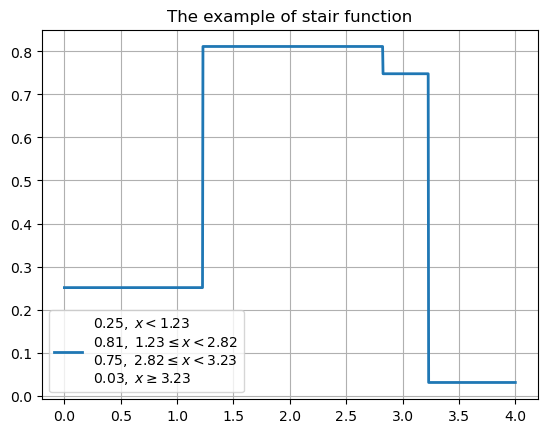

In [4]:
x0, x1 = 0, 4
n_stairs = 3
borders = x0 + (x1 - x0)*np.sort(np.random.random(n_stairs))
values = np.random.random(n_stairs + 1)

label = [r'${0:.2f}, \; {1:.2f} \leq x < {2:.2f}$'.format(values[i+1], 
                                                          borders[i], 
                                                          borders[i+1]) for i in range(n_stairs - 1)]
label = np.append(r'${0:.2f}, \; x < {1:.2f}$'.format(values[0], borders[0]), label)
label = np.append(label, r'${0:.2f}, \; x \geq {1:.2f}$'.format(values[-1], borders[-1]))
label = '\n'.join(label)

x = np.linspace(x0, x1, 1000)
y = stair_function(x, borders=borders, values=values)

plt.title('The example of stair function')
plt.plot(x, y, linewidth=2, label=label)
plt.legend()
plt.grid(True)
plt.show()

## Integral of stair function

For $\tau$ such that $\tau_i \leq \tau < \tau_{i+1}$ the integral of stair function $\nu$ will be:
$$
\int\limits_{\tau_0}^\tau \nu(t) dt = \sum\limits_{j=1}^i \nu_j(\tau_j - \tau_{j-1}) + \nu_{i+1}(\tau - \tau_i)
$$

In [5]:
def step_integral(x, x0=0, borders=[], values=[0], negative_backward=True):
    """
    Returns 
    """
    lengths_check(borders, values, raise_error=True)
    
    x1 = np.array(x)
    x0 = x0*np.ones(x1.shape)
    
    borders_ = np.concatenate([[-np.inf], borders, [+np.inf]])
    
    ones = np.ones(np.append(len(borders_), x1.shape).astype(int))
    res = ones*borders_.reshape(np.append(len(borders_), np.ones(len(x1.shape))).astype(int))
    res[res < x0] = (x0*ones)[res < x0]
    res[res > x1] = (x1*ones)[res > x1]
    res = res[1:] - res[:-1]
    res = res*np.array(values).reshape(np.append(len(values), np.ones(len(res.shape) - 1)).astype(int))
    res = res.sum(axis=0)
    
    if negative_backward and (x0 > x1).any():
        res[x0 > x1] = -step_integral(x=x0[x0 > x1], x0=x1[x0 > x1], borders=borders, values=values)
    
    return res

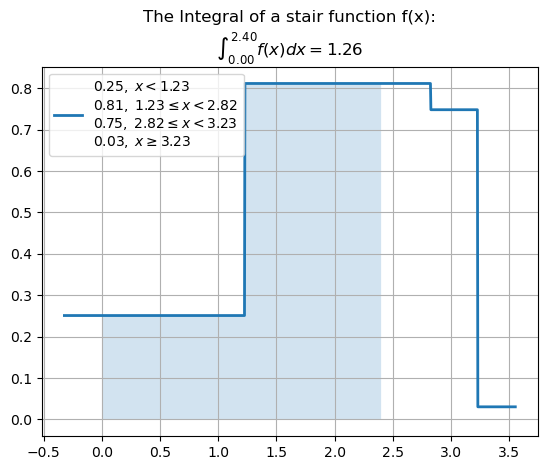

In [6]:
x0, x1 = 0, 2.4
int_val = step_integral(x1, x0, borders=borders, values=values)

xl = np.append(x0, borders).min()
xr = np.append(x1, borders).max()
xl, xr = xl - 0.1*(xr - xl), xr + 0.1*(xr - xl)

x = np.linspace(xl, xr, 1000)
y = stair_function(x, borders=borders, values=values)

x_int = np.linspace(x0, x1, 1000)
y_int = stair_function(x_int, borders=borders, values=values)

title = 'The Integral of a stair function f(x):\n' 
title += r'$\int_{{{0:.2f}}}^{{{1:.2f}}} f(x) dx = {2:.2f}$'.format(x0, x1, int_val)

plt.title(title)
plt.plot(x, y, linewidth=2, label=label)
plt.fill_between(x_int, y_int, alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()

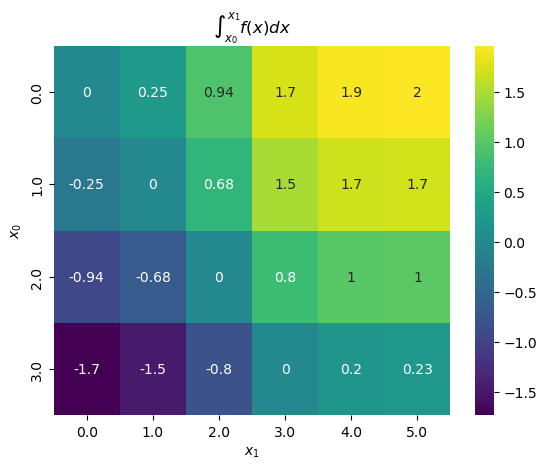

In [7]:
n = 4
m = 6
x0 = np.arange(n).reshape([n, 1])*np.ones([n, m])
x1 = np.arange(m).reshape([1, m])*np.ones([n, m])

int_vals = step_integral(x1, x0, borders=borders, values=values)

plt.title(r'$\int_{x_0}^{x_1} f(x) dx$')
sns.heatmap(pd.DataFrame(int_vals, 
                         columns=pd.Index(x1[0], name='$x_1$'), 
                         index=pd.Index(x0[:, 0], name='$x_0$')), 
            annot=True, cmap='viridis')
plt.show()

## $\chi$-invariant Elevation
$$
\lambda(\tau, \chi) = (\nu(\tau))^{1/n}\chi - \nu(\tau)\tau + \int\limits_0^{\tau}\nu(t) dt
$$

In [8]:
def elevation(tau, chi, n, borders=[], values=[0]):
    """
    """
    nu_val = stair_function(tau, borders, values)
    res = nu_val**(1/n)*chi - nu_val*tau + step_integral(x=chi, x0=0, borders=borders, values=values)
    return res

/tmp/ipykernel_16801/3508793855.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


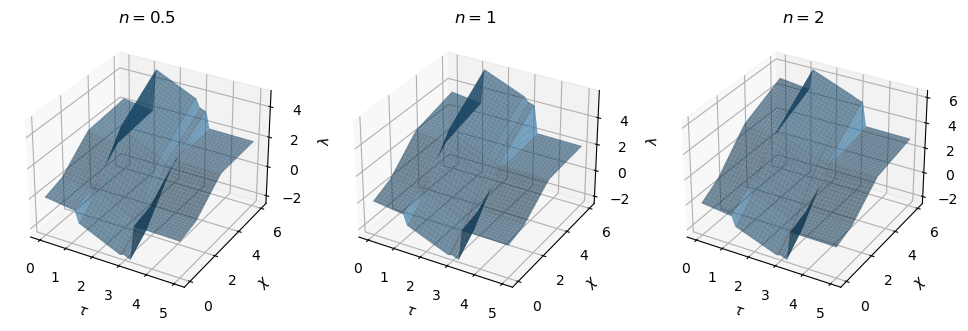

In [15]:
tau = np.linspace(0, 5, 40)
chi = np.linspace(0, 6, 40)

ns = [0.5, 1, 2]

taus = np.ones([len(tau), len(chi)])*tau.reshape([len(tau), 1])
chis = np.ones([len(tau), len(chi)])*chi.reshape([1, len(chi)])

fig, axs = plt.subplots(1, len(ns), subplot_kw={"projection": "3d"})

fig.set_figheight(6)
fig.set_figwidth(12)

for i, n in enumerate(ns):
    sols = elevation(taus, chis, n, borders=borders, values=values)
    
    axs[i].set_title(f'$n = {n}$')
    axs[i].plot_surface(taus, chis, sols, alpha=0.6)
    axs[i].set_xlabel(r'$\tau$')
    axs[i].set_ylabel(r'$\chi$')
    axs[i].set_zlabel(r'$\lambda$')

fig.show()